In [1]:
cd ../../..

/home/jovyan/work


In [2]:
# Start BPTK and automatically read the scenarios found in the scenarios folder
# this also loads all the Python classes referenced in the scenarios, so we are immediately ready 
# to run scenarios and plot results.

from BPTK_Py.bptk import bptk 

bptk = bptk()

# Agent-based Modeling with BPTK-Py

This document illustrates how to build agent-based simulation models (AB models) using the BPTK_PY framework.

Agent-based models are much more powerful than SD models - you can build any model you build with SD with ABM,  but not the other way round. This is because AB models are built using a programming language such as Python (and hence are Turing complete) as opposed to SD models, which are based on a simple mathematical formalism that is not Turing complete.

This power comes at a cost: While SD models are modelled visually using a simple graphical notation, ABMs are built using a programming language. This means you need good programming skills to create and understand them ABM models. They also tend to be much slower than SD models.

The objective of the BPTK_PY framework is to provide all the infrastructure code that is necessary for managing and running an agent-based model, so that the modeler can concentrate on creating the simulation logic.

The ABM framework integrates with the SD framework, in particular regarding scenario management and plotting of results - in fact the same model class is used in both frameworks, so you can even create hybrid models that contain stocks, flows and agents.

To illustrate agent-based modeling and how to do this with BPTK_PY, we will build an agent-based version of the simple project management model. This model is an illustration of [Parkinson's law](https://en.wikipedia.org/wiki/Parkinson%27s_law), which states that work expands so as to fill the time available for its completion - Parkinson's law is particularly relevant in projects, where we need to set milestones judiciously to ensure that schedule pressure remains at an acceptable rate.

You can find a discussion of an SD version of the model [here](bptk_py_sd_dsl_intro.ipynb)

## A Brief Introduction To Agent-based Modelling

The basic concept behind AB models is quite simple: you populate an environment (the model) with a set of agents. Agents and the environment each have a set of properties and each agent must always be in a defined state. Agents can perform actions and interact amongst each other and with the environment by sending each other events - the agents react to these events by updating their properties and/or changing their state.

So to create an agent using Python and the BPTK_PY framework, all you really need to do is:

* Identify the relevant agents
* Define the agents properties
* Define an action method, which describes what the agent does in each time-step, e.g. perform internal tasks and send events to other agents
* Define handlers for each kind of event you want your agent to react to
* For each agent, implement an initializer which sets the agents initial state

Defining the model is even easier:

* Define the environment properties and update them when necessary
* Tell the model which kinds of agents there are

Then, to configure the simulation, all we need to do is to set the initial values of the properties and instantiate the initial agents. Each unique configuration of a model is refered to as a scenario. The BPTK_PY framework helps you to manage different scenarios and compare results easily.

Much like with the SD models, configuring AB models is best done using a config file defined in JSON.

## The Simple Project Management Model As An Agent-based model

The purpose of the model is to investigate how long it takes to complete a set of task within a given deadline.

The model is an illustration of [Parkinson's law](https://en.wikipedia.org/wiki/Parkinson%27s_law), which states that work expands so as to fill the time available for its completion.

The underlying assumption is that our productivity isn't linear, but depends on schedule pressure:

* The higher the schedule pressure, the higher my productivity will be (within limits)
* The lower the schedule pressure, the lower the productivity will be (again within limits)

Here is the productivity curve we use in the model:

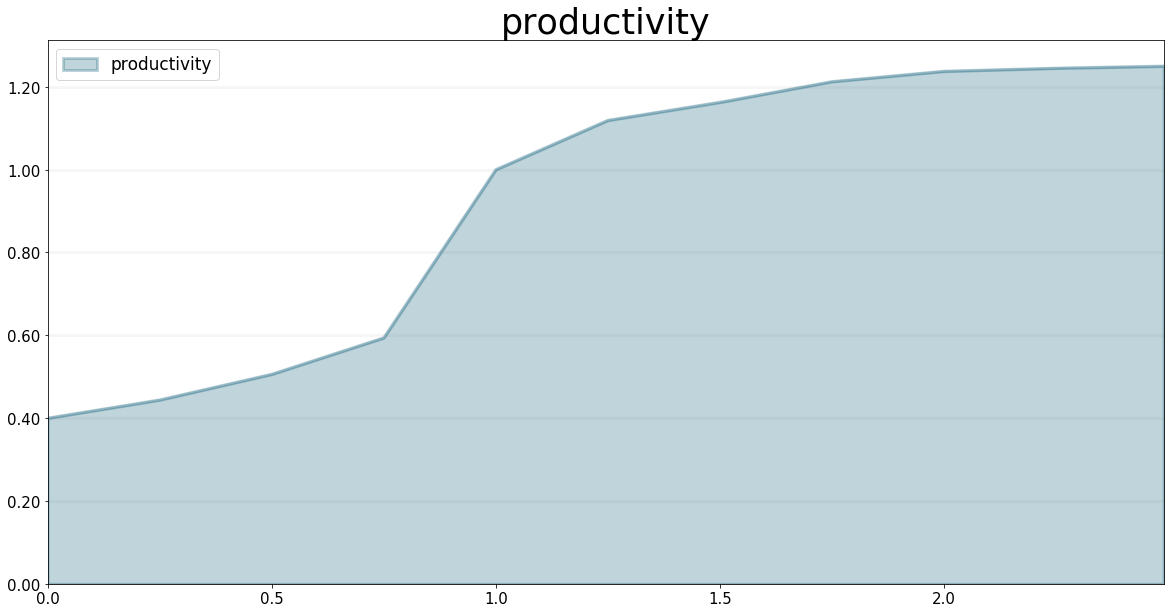

In [3]:
(
bptk.scenario_manager_factory
 .get_scenario("ABMsmSimpleProjectManagement","scenario100")
 .model
 .plot_lookup(["productivity"])
)

Now let's think about how to model this using agent-based modeling.

* We have two kinds of agents, `staff_member` and `task`.
* Staff members can either be available or busy working on a task. Staff members only have one property: the task they are currently working on.
* Tasks are either, open, in progress, or closed. Tasks have an `effort` property defining the initial effort per task and a `remaining_effort` property which tracks how much more effort needs to be invested into a task in order to complete it.
* Staff Members send the `task_started` event to a task when they start working on a task and a `task_progress` event every time they do some work on the task.
* The model provides the overall productivity property and the deadline.
* A staff member only works on one task at a time.

The simulation runs through a number of time steps - in each time step, each staff member checks first checks its status. If it is `available`, then the staff members grabs the next open task and changes its status to `busy`. It also sends a `task_started` event to the task, to ensure no other staff member will start working on the task.

If it is `busy` then it continues working on the task at hand and send a `task_progress` event to the task. In the event it records the amount of work done on the task.

At the end of the timestep, the staff members checks to see whether the task is completed - if yes, it changes its state back to `available`.

Tasks are even simpler, because they don't perform actions of their own, all they do is respond to events:

* If a task receives the `task_started` event, it changes its status to `in_progress`.
* If it receives the `in_progess` event, it reduces the remaining effort by the amouht defined in the event and then checks the remaining effort – if this is zero, it changes its state to `closed`.

That's really all there is to it!

Before we take a look at how to implement this in Python using the BPTK_PY Framework, let's take a look at the simulation results.

Assuming that each task takes one day to complete when productivity is equal to one, here are the simulation results for a deadline of 100 days and 80, 100 and 120 tasks respectively:

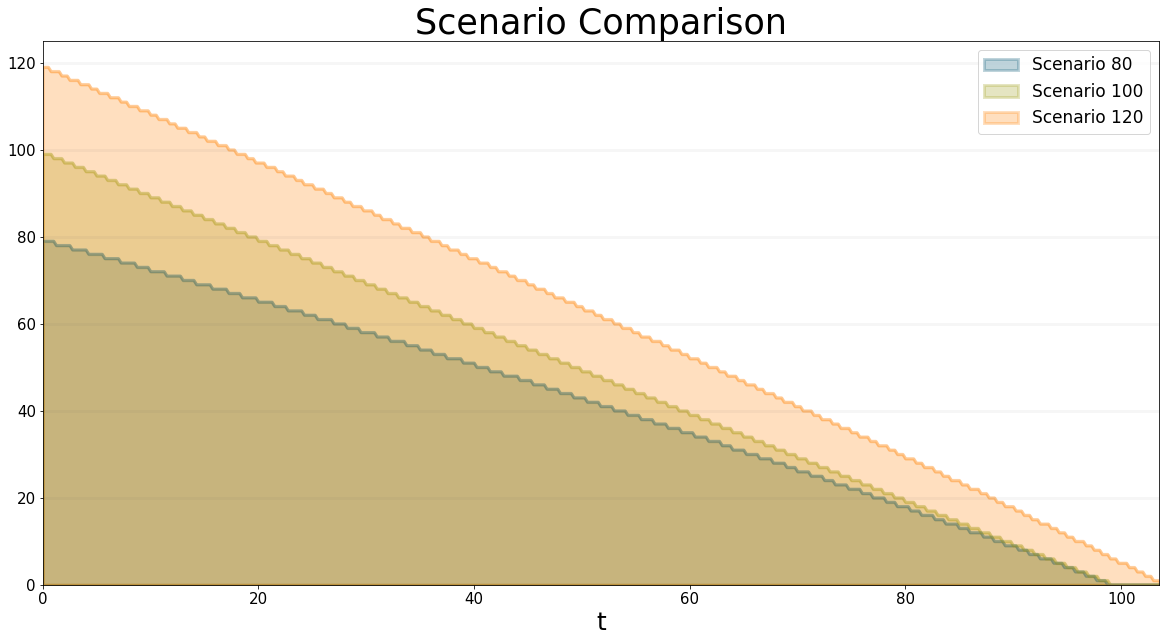

In [4]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    title="Scenario Comparison",
    agents=["task"],
    agent_states=["open"],
     series_names={
         "ABMsmSimpleProjectManagement_scenario80_task_open" : "Scenario 80",
         "ABMsmSimpleProjectManagement_scenario100_task_open" : "Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_task_open" : "Scenario 120",
     }
)

You can see that a project with 80 tasks still takes 100 days and a project with 120 tasks completes much faster than expected.
You can see why this happens when you plot the productivity - this is quite different for each of the scenarios:
* In the 80 scenario, the productivity is very low initially and then goes up as the deadline approaches.
* In the 100 scenario, the productivity is at one right up to the deadline.
* In the 120 scenario, the productivity is high right from the word go.


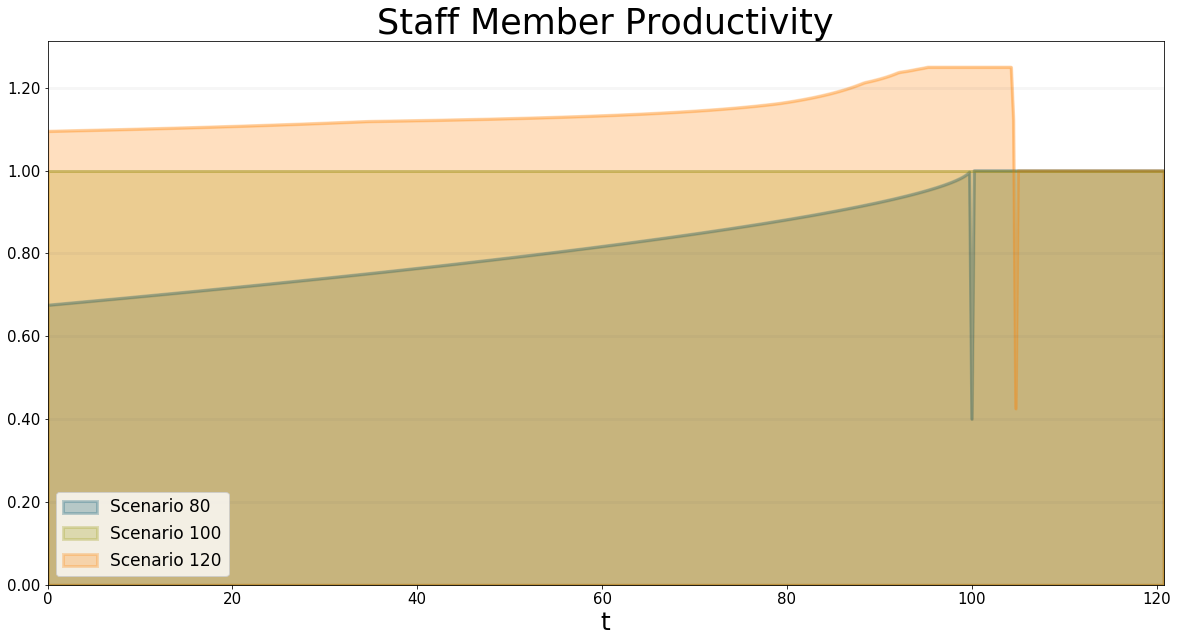

In [5]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    agents=["controlling"],
    agent_states=["active"],
    title="Staff Member Productivity",
    agent_properties=["productivity"],
    agent_property_types=["mean"],
     series_names={
         "ABMsmSimpleProjectManagement_scenario80_controlling_active_productivity_mean" : "Scenario 80",
         "ABMsmSimpleProjectManagement_scenario100_controlling_active_productivity_mean" : "Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_controlling_active_productivity_mean" : "Scenario 120",
     }
)

We can also take a look at how schedule pressure develops over time:

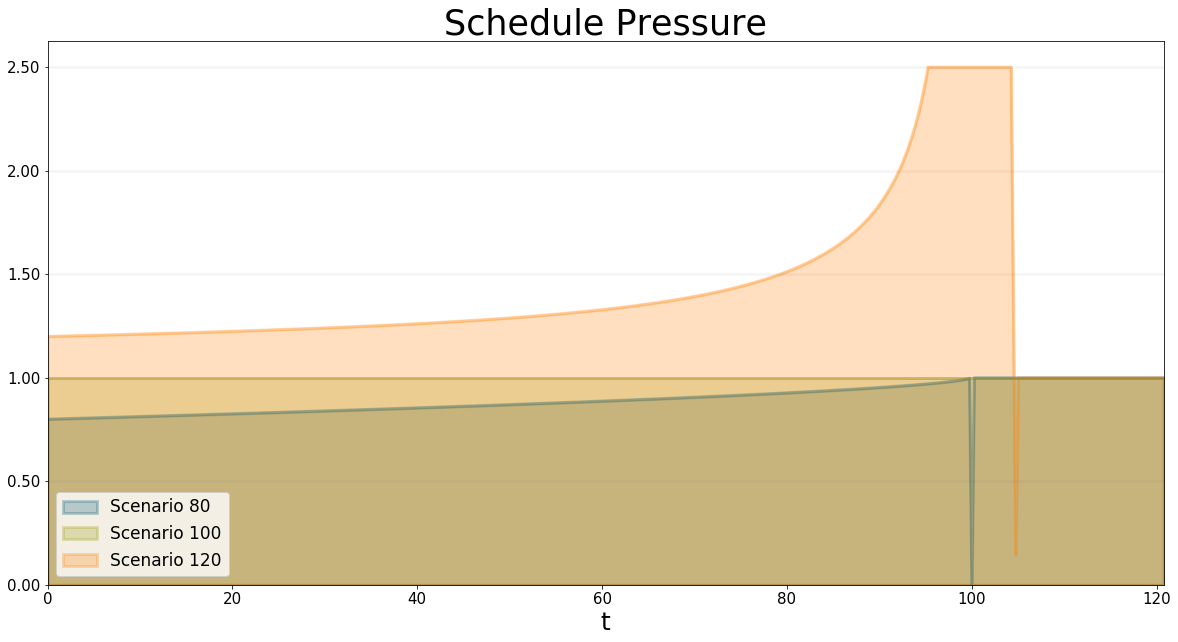

In [6]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    agents=["controlling"],
    title="Schedule Pressure",
    agent_states=["active"],
    agent_properties=["schedule_pressure"],
    agent_property_types=["mean"],
     series_names={
         "ABMsmSimpleProjectManagement_scenario80_controlling_active_schedule_pressure_mean" : "Scenario 80",
         "ABMsmSimpleProjectManagement_scenario100_controlling_active_schedule_pressure_mean" : "Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_controlling_active_schedule_pressure_mean" : "Scenario 120",
     }
)

Now let's take a look at how to implement the model in Python using the BPTK_PY framework.

## Implementing the Simple Project Managment Model in Python using BPTK_PY

You can find the code for this model in the `/abm/spm` directory of the BPTK_PY tutorial.

First let's take a look at the `act` method of the staff member agent, which implements the logic outline above:

Right at the beginning of the method the `work_capacity` for this time step is calculated. This represents the maximum amount of work the staffMember is able to do in this time step, given his current productivity - the actual amount of work performed may be less, because all tasks could be complete.

So now the staff member goes into a loop which only stops once all the work capacity has been used up.

If the staff member is currently in the available state (i.e. it is not working on an open task), it grabs the next available open task by calling the `self.model.next_agent` method. If there are no more tasks, then there is nothing left to do and work_capacity is set to zero. 

If there is a task, then the state of the staff member is set to `busy` and the task is sent a `task_started` event.

If the staff member is currently busy, then the actual work done in this step is calculated - this depends on the work capacity and the tasks remaining effort.

```python

   def act(self, time, round_no, step_no):

        work_capacity = self.model.dt * self.model.productivity

        while work_capacity > 0:
            if self.state == "available":

                self.task = self.model.next_agent("task", "open")

                if self.task is not None:

                    self.state = "busy"
                    self.task.receive_instantaneous_event(
                        Event("taskStarted", self.id, self.task.id)
                    )
                else:
                    # no more open tasks
                    work_capacity = 0

            if self.state == "busy":

                # the actual progress we make on a task depends on the remaining effort

                work_done = min(work_capacity, self.task.remaining_effort)
                work_capacity -= task_progress

                self.task.receive_instantaneous_event(
                    Event(
                         "taskProgress",
                        self.id,
                        self.task.id,
                        {"progress": work_done}
                     )
                )

                if self.task.state == "closed":
                    self.state = "available"
                    self.task = None

```

Note that the staff members properties such as productivity and current_progress are accessed using dot-notation (e.g. self.productivity). But no getters or setters need to be set up for these properties - all you need to do is define the agent properties in the config file or define properties in the agents initialize method, the syntax used is identical in either case.

In our model we don't need to set staff members properties in the scenario file, because its properties are not relevant for differentiating between scenarios. Here is what the staff members initialize method looks like:
```python
    def initialize(self):

        self.agent_type = "staffMember"
        self.state = "available"
        self.set_property("current_progress", {"type": "Double", "value": 0})
        self.set_property("productivity", {"type": "Double", "value": 1})
        self.set_property("task", {"type": "Agent", "value": None})

```
The initialize method of an agent is called by the framework right after an agent has been created. We use the method to set the type of the agent (i.e. `staffMember` in this case) and also its initial state (i.e. `available`).

Properties set using the `set_property` method can be accessed using dot-notation – this saves a lot of boilerplate code. Also statistics are automatically collected for these properties, these statistics can then be output in a dataframe or plotted using the `plot_scenario` method. Currently the `total`, the `mean` value and `min` and `max` are collected for each agent property per agent state.

Now let's take a look at how the `task`is implemented - the task doesn't actually do anything, so we don't need to implement an act method. All we need is handlers for the `taskStarted` and `taskProgress`events:

The handler for the started event just changes the tasks state from `open` to `inProgress`:
```python
    def handle_started_event(self, event):
        self.state = "in_progress"
```
The handler for the progress event adjusts the remaining effort according to the progress information sent by the `staff_member`. If the remaining effort is zero, it changes its state to `closed`.

```python
    def handle_progress_event(self, event):
        self.remaining_effort = max(self.remaining_effort-event.data["progress"], 0)

        if self.remaining_effort == 0:
            self.state = "closed"
```

The only thing that remains to be done is to register the event handlers - this is done in the tasks `initialize` method:
```python
   def initialize(self):
        self.agent_type = "task"
        self.state = "open"

        self.set_property("remaining_effort", {"type": "Double", "value": self.effort})

        self.register_event_handler(["open"], "task_started", self.handle_started_event)
        self.register_event_handler(["in_progress"], "task_progress", self.handle_progress_event)
```

We need to call the `register_event_handler` method for each event. We pass the handler as a function along with the event name and a list of states the handler is relevant for.

The only remaing class we need to look at is the SPM model itself. The key method in the model class is the `initialize_model` method - this method is called automatically by the framework, it is used to register the agent factories. Agent factories are simple, anonymous functions which instantiate agents by calling their constructors and passing an agent id, the model the agent is part of and the agent properties (which are defined in the scenarios config file).

Here is what the `initialize_model` method in the SPM class, which derived from the Model class in the BPTK PY framework:

```python
def instantiate_model(self):
        self.register_agent_factory(
            "staffMember",
            lambda agent_id, model, properties: StaffMember(agent_id, model, properties)
        )
        self.register_agent_factory(
            "task", 
            lambda agent_id, model, properties: Task(agent_id, model, properties)
        )
```

The SPM class automatically provides access to all the properties set in the scenario config file via dot-notation: in this case these are the properties `deadline` and `productivity`. This access is provided automatically, using Python metaprogramming techniques.

If you take a look at the config file for the simulation (`abm_spm.json`) you will see that the constants are defined like this:

```json
       "properties": [
         {
            "name": "deadline",
            "type": "Integer",
            "value": 120
          },
          {
            "name": "productivity",
            "type": "Lookup",
            "value": [
                      [0, 0.4],
                      [0.25, 0.444],
                      [0.5, 0.506],
                      [0.75, 0.594],
                      [1, 1],
                      [1.25, 1.119],
                      [1.5, 1.1625],
                      [1.75, 1.2125],
                      [2, 1.2375],
                      [2.25, 1.245], 
                      [2.5, 1.25]
                     ]
          }
        ]
```

In our SPM model, providing agents with the productivity lookup directly doesn't really make much sense - the agents are interested in the productivity at the current time (i.e. the "instantaneous" productivity), which depends on the current schedule pressure, which itself is defined as the ratio of the required effort to complete the remaining tasks over the remaining work capacity. This is an overall property of the project (i.e. the model) and not of the agents.

So in order to provide agents with access to these values, we create two model properties called `schedule_pressure` and `productivity`.

We need to be careful though - our model could potentially have many staff members, and we need to ensure that
they all get the same value of `schedule_pressure` and `productivity` - we need to ensure that the values of these properties are only updated once at the beginning of each round.

This is what the models `act` method is for - it is called by the scheduler at the beginning of each round, before the agents `act` methods are called.

We've included the code for the `act` method below, here is how schedule pressure and productivity are calculated:

First the `remaining_effort` for all open tasks is calculated by walking along the list of remaining open tasks and reading their `effort` property. This list is accessed using the models's `agent_ids` method, which is provided by the BPTK_PY framework. To this effort we need to add the remaining_effort of the task currently being worked on.

We then add the remaining effort for all the tasks that are currently being worked on, by all staff members.

We can then work out the remaining work capacity by multiplying the remaing time until the deadline with the number of staff members (assuming that all staff members work on tasks full time).

The schedule pressure is then simply the ratio of the remaining effort and the work capacity (we need to ensure the value is never greater than 2.5, because the productivity lookup is only defined in the range between 0 and 2.5.

Once we know the schedule pressure, we can work out the productivity using the productivity lookup.

```python
       def act(self, time, sim_round, step):
        # schedule pressure and productivity are updated once at the beginning of each round
        # this ensures that they are constant within each round
        # and thus the same for all staff members

        remaining_effort = 0

        # calculate the remaining effort for all open tasks

        task_ids = self.agent_ids("task")

        for task_id in task_ids:
            task = self.agent(task_id)

            if task.state == "open":
                remaining_effort += task.effort

        # now add the remaining effort for the tasks currently being worked on

        staff_ids = self.agent_ids("staff_member")

        for staff_id in staff_ids:
            task_in_progress = self.agent(staff_id).task
            if task_in_progress is not None:
                remaining_effort += task_in_progress.remaining_effort

        remaining_time = self.deadline - self.scheduler.current_time
        num_staff_members = self.agent_count("staff_member")

        if remaining_time > 0:
            self._schedule_pressure = min(remaining_effort/(remaining_time * num_staff_members), 2.5)
        elif remaining_effort > 0:
            self._schedule_pressure = min(remaining_effort/(self.dt * num_staff_members), 2.5)
        else:
            self._schedule_pressure = 1

        productivity_lookup = self.get_property("productivity")

        self._productivity = self.lookup(
                self._schedule_pressure,
                productivity_lookup["value"])
```

Note that there is a potential naming conflict because we now have two properties called `productivity` – in practice this is no problem, because properties implemented as methods of the class take precedence over the properties defined using the config file or the `set_property` method. You can still access these properties using get_property.

## Running The Model

Now we've seen the code, let's see the model in action.

The BPTK framework is loaded with the following lines:

```python
## Start BPTK and automatically read the scnearios found in the scenario folder

from BPTK_Py.bptk import bptk 

bptk = bptk()
```
These lines not only load the BPTK framework, they also start a background process that reads the config files found in the `scenarios` folder, loads the corresponding ABM and SD model and confgiures them according to the scenarios.

And thats all - once a model has been configured for each scenario defined, we can run the scenario/model using the `plot_scenario`function:

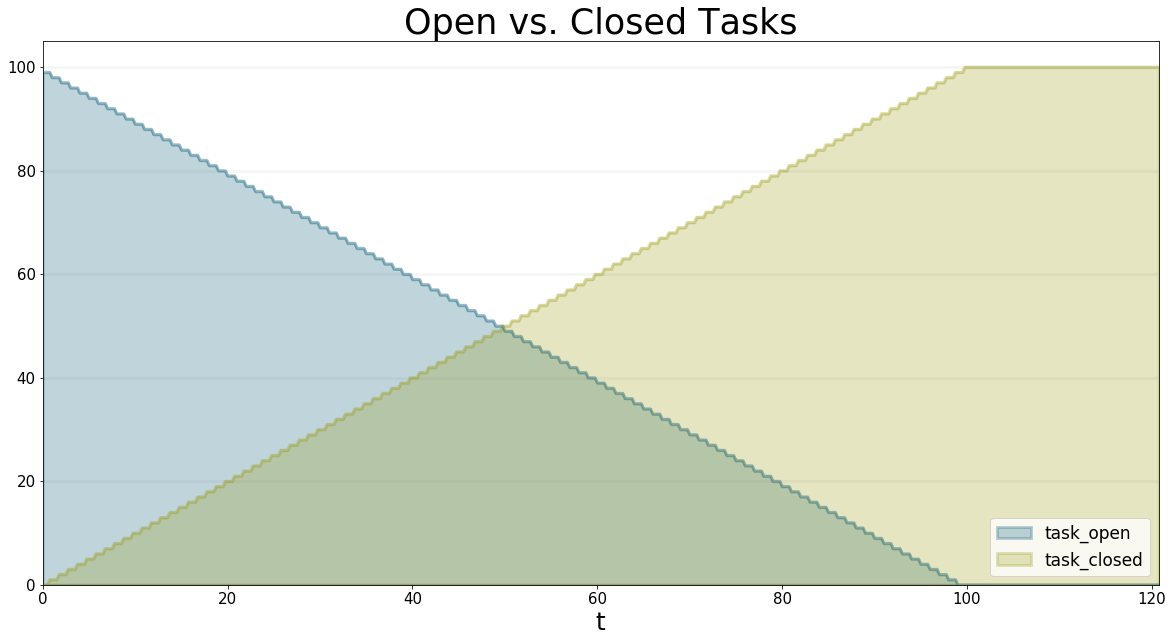

In [7]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    title="Open vs. Closed Tasks",
    scenarios=["scenario100"],
    agents=["task"],
    agent_states=["open","closed"],
)

We can easily compare the results from different scenarios to each other:

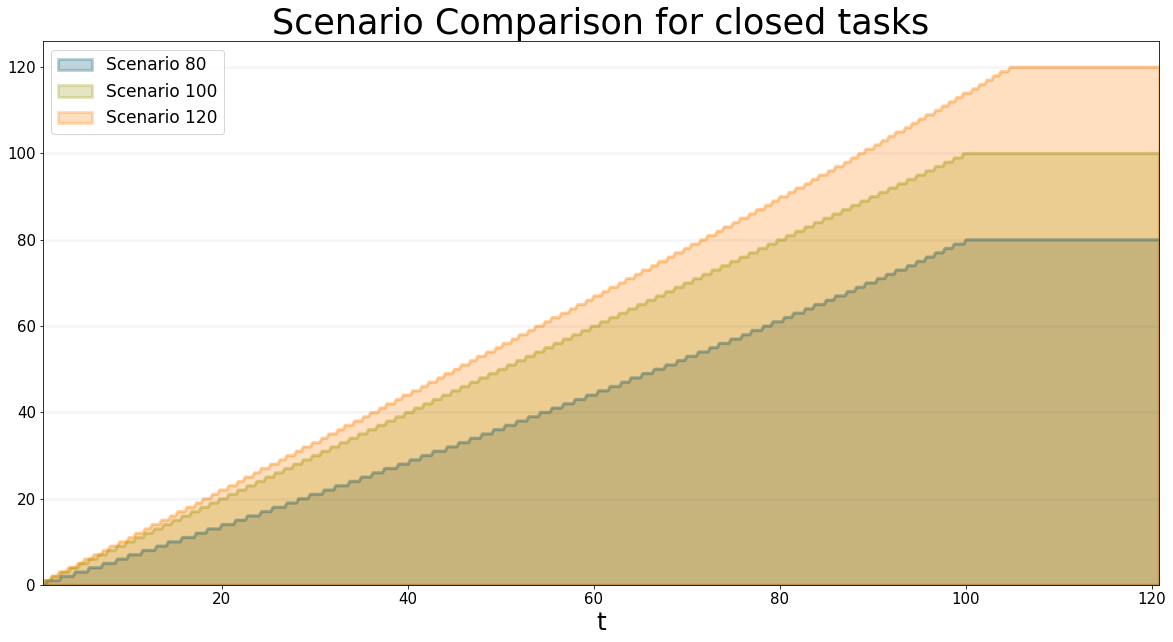

In [8]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    title="Scenario Comparison for closed tasks",
    agents=["task"],
    agent_states=["closed"],
     series_names={
         "ABMsmSimpleProjectManagement_scenario80_task_closed" : "Scenario 80",
         "ABMsmSimpleProjectManagement_scenario100_task_closed" : "Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_task_closed" : "Scenario 120",
     }
)

We can also take a look at the underlying data:

In [9]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    agents=["task"],
    agent_states=["open"],
    return_df=True,
     series_names={
         "ABMsmSimpleProjectManagement_scenario80_task_open" : "Scenario 80",
         "ABMsmSimpleProjectManagement_scenario100_task_open" : "Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_task_open" : "Scenario 120",
     }
)[95:120]

,Scenario 80,Scenario 100,Scenario 120
t,,,
95.00,4.0,4.0,11
95.25,4.0,4.0,11
95.50,4.0,4.0,11
95.75,3.0,4.0,10
96.00,3.0,3.0,10
96.25,3.0,3.0,10
96.50,3.0,3.0,10
96.75,2.0,3.0,9
97.00,2.0,2.0,9


And we can also plot the values of the agent properties:

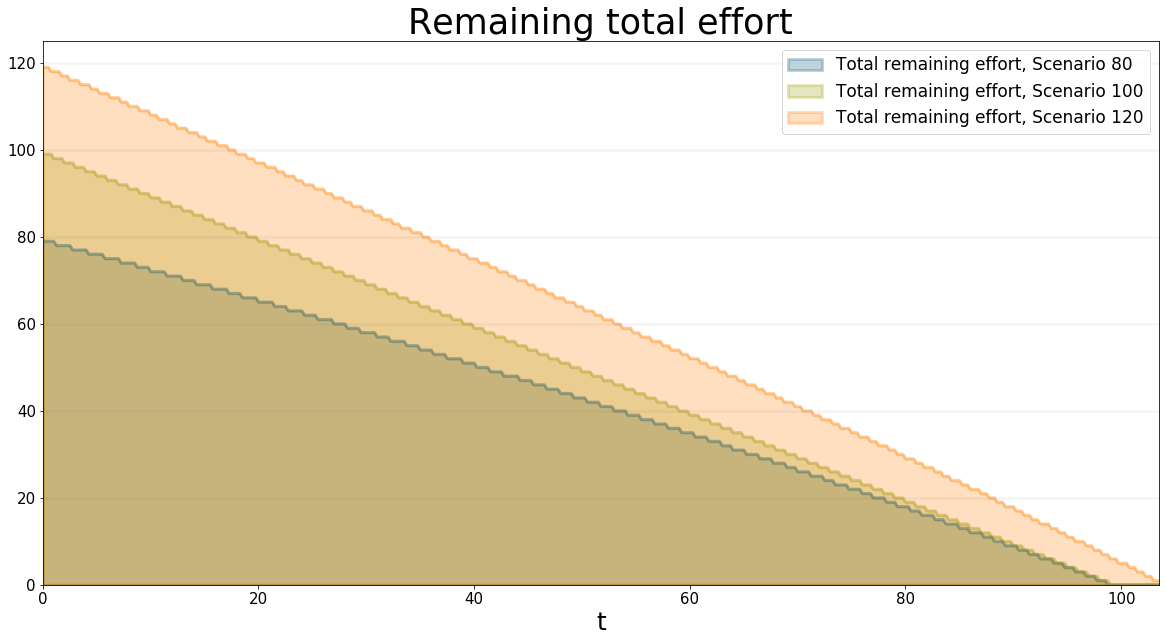

In [10]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario100","scenario120"],
    title="Remaining total effort",
    agents=["task"],
    agent_states=["open"],
    agent_properties=["effort"],
    agent_property_types=["total"],
    series_names={
        "ABMsmSimpleProjectManagement_scenario80_task_open_effort_total": "Total remaining effort, Scenario 80",
        "ABMsmSimpleProjectManagement_scenario100_task_open_effort_total": "Total remaining effort, Scenario 100",
         "ABMsmSimpleProjectManagement_scenario120_task_open_effort_total": "Total remaining effort, Scenario 120"
     }
)

We can even compare two scenarios with the same settings but different time steps. The simulations time step essentially defines the granularity at which measurements take place – in this case the simulation with a granularity of 4 steps per time unit is "faster" than the same simulation with 1 time step per unit – this is natural if you think about it: in the former scenario, we check much more often if we have completed a task and thus can move on to a new task sooner.

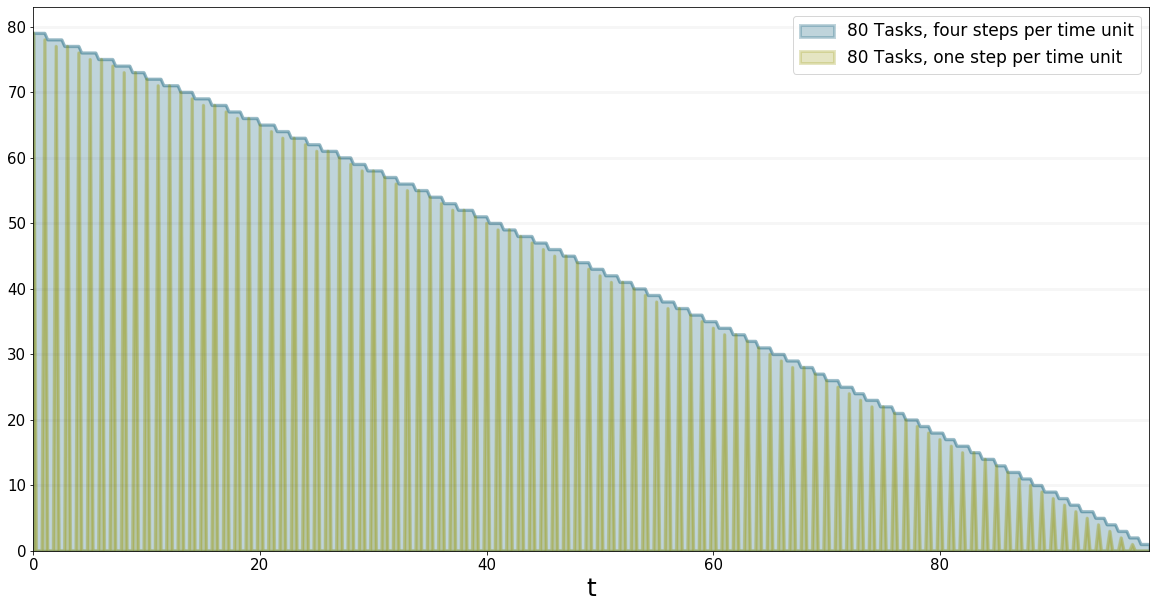

In [11]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario80","scenario80DT1"],
    agents=["task"],
    agent_states=["open"],
    series_names={
        "ABMsmSimpleProjectManagement_scenario80_task_open":"80 Tasks, four steps per time unit",
        "ABMsmSimpleProjectManagement_scenario80DT1_task_open":"80 Tasks, one step per time unit",
    }
)

We can also see what happens if we double the number of staff members - adding new staff members reduced productivity, unless the deadline is adjusted.

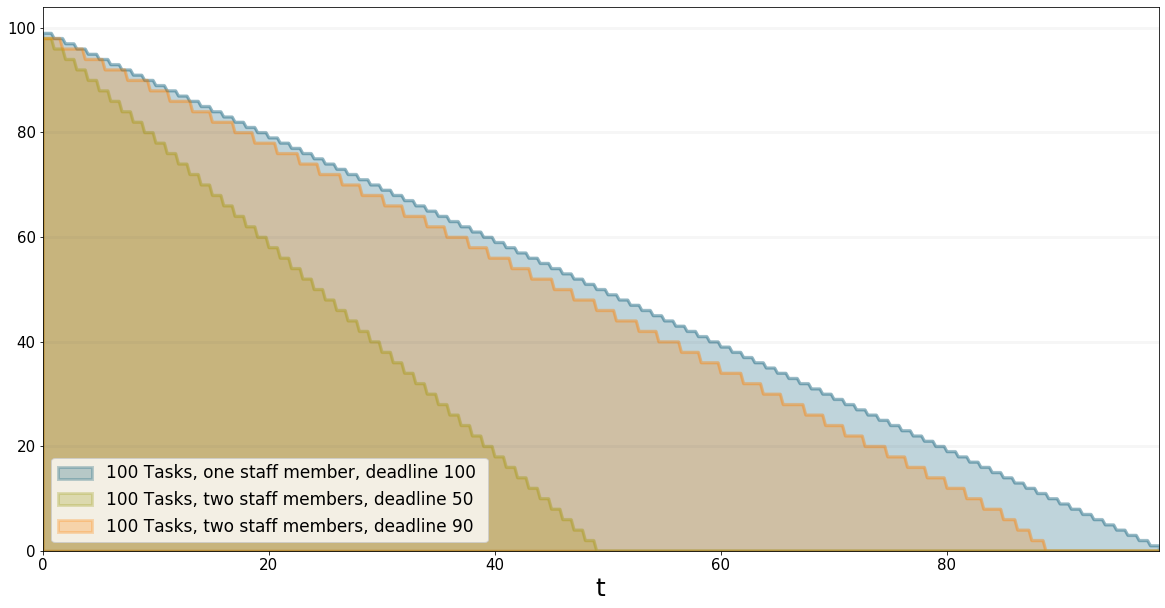

In [12]:
bptk.plot_scenarios(
    scenario_managers=["ABMsmSimpleProjectManagement"],
    kind="area",
    scenarios=["scenario100","scenario100SM2D50","scenario100SM2D90"],
    agents=["task"],
    agent_states=["open"],
    series_names={
        "ABMsmSimpleProjectManagement_scenario100_task_open":"100 Tasks, one staff member, deadline 100 ",
        "ABMsmSimpleProjectManagement_scenario100SM2D50_task_open":"100 Tasks, two staff members, deadline 50",
        "ABMsmSimpleProjectManagement_scenario100SM2D90_task_open":"100 Tasks, two staff members, deadline 90",
    }
)

## Visualising Agent States Using The AgentStatusWidget
Agent based simulations can take a very long time. Visualizations with widgets can visualize the progress of the simulation by monitoring agent states.

As of now, the framework comes with a widget to show states of the agents. In order to use progress widgets, you need to implement the method ``build_widget()`` in your Agent based model implementation. 
The following is an example that tracks the states of all task agents. You need to map which states to monitor and create a widgetLoader. The widgetLoader loads the specified class and you need to hand over all arguments for the widget:

```python
    def build_widget(self):
        widget_loader = WidgetLoader()
        states = {1: "in_progress", 2: "closed"}
        agents = [agent for agent in self.agents if agent.agent_type == "task"]
        
        widget_loader.create_widget("AgentStatusWidget", states=states, agents=agents)
        
        return widget_loader
```

We can then run the widget using the following code:

In [ ]:
f=bptk.run_abm_with_widget(scenario_manager="ABMsmSimpleProjectManagement",scenario="scenario100",agents=["task"],
    agent_states=["open","closed"])

## Summary

This was a brief introduction to agent-based modeling and simulation using the BPTK_PY framework. Here is a summary of the key points:

* The BPTK_PY framework supports System Dynamics models in XMILE Format, native SD models, Agent-based models and hybrid SD-ABM-Models
* The objective of the framework is to provide the infrastructure for managing model settings and scenarios and for running and plotting simulation results, so that the modeller can concentrate on modelling.
* The framework automatically collect statistics on agents, their states and their properties, which makes plotting simulation results very easy.
* Simulation results can also be returned as Pandas dataframes.
* The framework uses some advanced Python metaprogramming techniques to ensure the amount of boilerplate code the modeler has to write is kept to a minimum.
* Model settings and scenarios are kept in JSON files. These settings are automatically loaded by the framework upon initialization, as are the model classes themselves. This makes interactive modeling, coding and testing using the Jupyter environment very painless.